# Steps to perform (Project level)

1) Fetch the data from Kaggle, analyze it with statistical descriptions and visualizations (pandas profiler), time series analysis, perform dimensionality reduction, clean it (impute missing data), subsample data and handle class imbalance.
2) Load data to S3 and Create train, validation and test dataset on AWS Sagemaker (CV)
3) Decide upon the best metric
4) Use Autoglunon for identifying the best model
5) Perform hyperparameter tuning (regularization, ensure overfitting)
6) Train the model
7) Test the model
8) Deploy the model
9) Create lambda to interact with model
Bonus:
10) Attempt inference with batch processor
11) Try to deploy 2 different models with bagging and boosting
12) Test the results on Kaggle

Surplus:
Python documentation and comments convention

In [21]:
!pip install autogluon --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 135.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 264.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.3/218.3 kB 353.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 357.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 254.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 242.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 338.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 168.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 360.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 147.9 MB/s eta 0:00:00
  Installing build

In [22]:
# Import required packages
import sagemaker
import pandas as pd
from autogluon.tabular import TabularPredictor

In [6]:
#Set Sagemaker variables
session = sagemaker.Session()
def_bucket = session.default_bucket()
role = sagemaker.get_execution_role()

In [7]:
#Ensure Sagemaker variable values are correctly set
print("Default Bucket: {}".format(def_bucket))
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-004538843871
RoleArn: arn:aws:iam::004538843871:role/service-role/AmazonSageMaker-ExecutionRole-20230328T233092


In [10]:
bucket = "mle-capstone"
prefix = ""

In [11]:
# Command to download and unzip data (This command needs to be executed once)
session.download_data(path="data", bucket=bucket, key_prefix=prefix)

In [13]:
!unzip data/Data.zip

Archive:  data/Data.zip
   creating: Data/
  inflating: Data/valid.csv          
  inflating: __MACOSX/Data/._valid.csv  
  inflating: Data/test.csv           
  inflating: Data/train.csv          
  inflating: __MACOSX/Data/._train.csv  


In [18]:
df_train = pd.read_csv("Data/train.csv", parse_dates=["S_2"])
df_train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-03-15,0.400025,0,0.954861,0.023890,0.003140,NaN,0.0,1.175081,...,-1,-1,1,0,0.870115,0.141214,1,0.008945,8,1
1,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-04-14,0.405788,0,0.944042,0.025613,0.008950,NaN,0.0,1.177973,...,-1,-1,1,0,0.864712,0.145885,1,0.002125,8,1
2,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-05-15,0.403615,1,0.940261,0.026016,0.009074,NaN,0.0,1.175785,...,-1,-1,1,0,0.871729,0.144555,1,0.000765,8,1
3,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-06-14,0.391495,1,0.936253,0.029538,0.005778,NaN,0.0,1.174703,...,-1,-1,1,0,0.869414,0.151890,1,0.008195,8,1
4,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-07-15,0.392356,1,0.915764,0.028671,0.008595,NaN,0.0,1.177958,...,-1,-1,1,0,0.869089,0.152654,1,0.001493,8,1


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91000 entries, 0 to 90999
Columns: 191 entries, customer_ID to target
dtypes: datetime64[ns](1), float64(93), int64(96), object(1)
memory usage: 132.6+ MB


In [20]:
df_train.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
count,90281.000000,91000.000000,91000.000000,90965.000000,9.100000e+04,76926.000000,90965.000000,9.096500e+04,17723.000000,6.613500e+04,...,91000.000000,91000.000000,91000.000000,91000.000000,89157.000000,17783.000000,91000.000000,9.018300e+04,91000.000000,91000.000000
mean,0.568774,6.033396,0.172012,0.509358,1.301276e-01,0.264691,0.088831,1.896802e-01,0.219048,1.926127e-01,...,-0.948341,-0.932011,0.175165,0.021473,0.183513,0.385616,0.174923,5.315704e-02,0.721429,0.500000
std,0.263183,10.828274,0.249182,0.420232,2.944498e-01,0.225281,0.266071,2.702376e-01,0.219233,2.639075e-01,...,0.223661,0.316583,0.430104,0.197013,0.368375,0.245485,0.429922,1.841149e-01,2.392056,0.500003
min,-0.383019,0.000000,-0.719199,0.000003,2.970408e-08,-0.254707,0.000000,4.138581e-07,-0.000219,8.705647e-07,...,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-0.013947,-1.000000,2.310564e-07,-1.000000,0.000000
25%,0.380897,0.000000,0.012775,0.045602,3.145549e-03,0.140905,0.000000,6.640857e-03,0.070178,4.943353e-02,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.183598,0.000000,2.752826e-03,0.000000,0.000000
50%,0.560543,0.000000,0.059323,0.716888,6.304529e-03,0.174531,0.000000,3.551676e-02,0.163329,1.091969e-01,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.365097,0.000000,5.498154e-03,0.000000,0.500000
75%,0.800548,9.000000,0.219176,1.000031,9.468716e-03,0.325789,0.000000,2.926849e-01,0.299528,2.338837e-01,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.560140,0.000000,8.276601e-03,0.000000,1.000000
max,1.009998,181.000000,1.324053,1.010000,2.507711e+00,2.648462,5.465303,1.625262e+00,2.685152,9.089694e+00,...,1.000000,3.000000,1.000000,1.000000,1.174753,1.751388,1.000000,1.343284e+00,47.000000,1.000000


In [29]:
df_test = pd.read_csv("Data/test.csv", parse_dates=["S_2"])
df_test.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,fdfe651aa0bb6785a05e071566572b20137019cfc90ef0...,2017-07-12,0.604238,0,0.025067,0.407035,0.005540,0.273283,0.412313,0.061583,...,-1,-1,0,0,0.0,NaN,0,0.001911,0,0
1,fe717661c0f018128be13a54fac5ce27021f218b9d8576...,2017-12-06,0.638847,13,0.562745,0.023085,0.002721,0.122671,0.000000,0.376701,...,-1,-1,0,0,0.0,NaN,0,0.005178,0,0
2,fe0dccd5b37bf9932b433613a0a925dc04a50bb6b2736f...,2018-03-04,0.827235,13,0.012856,1.006770,0.004760,0.270789,0.000000,0.007562,...,-1,-1,0,0,0.0,NaN,0,0.008859,0,0
3,fde26d2b87a5d557510f9af9937dfe8707c4b12001a990...,2017-06-16,0.957176,3,0.040668,1.002427,0.001250,0.080765,0.000000,0.003937,...,-1,-1,0,0,0.0,NaN,0,0.008382,0,0
4,fe0038b18c4beaec66a4b3743d0c9396a55e409145be0e...,2017-06-13,0.984523,20,0.005058,1.004929,0.000806,-0.040735,0.080824,0.005039,...,-1,-1,0,0,0.0,NaN,0,0.003288,0,0


In [23]:
predictor = TabularPredictor(label="target", learner_kwargs = {"ignored_columns":["customer_ID","S_2"]}, eval_metric="accuracy").fit(train_data=df_train, time_limit=600, presets = "best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20230328_203010/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230328_203010/"
AutoGluon Version:  0.7.0
Python Version:     3.10.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Dec 8 01:29:11 UTC 2022
Train Data Rows:    91000
Train Data Columns: 190
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Genera

[1000]	valid_set's binary_error: 0.0482637


	Ran out of time, early stopping on iteration 1263. Best iteration is:
	[1257]	valid_set's binary_error: 0.0394725


[1000]	valid_set's binary_error: 0.0534505


	Ran out of time, early stopping on iteration 1303. Best iteration is:
	[1299]	valid_set's binary_error: 0.0422857


[1000]	valid_set's binary_error: 0.0518681


	Ran out of time, early stopping on iteration 1307. Best iteration is:
	[1287]	valid_set's binary_error: 0.0414066


[1000]	valid_set's binary_error: 0.0540659


	Ran out of time, early stopping on iteration 1293. Best iteration is:
	[1291]	valid_set's binary_error: 0.042989


[1000]	valid_set's binary_error: 0.0521319


	Ran out of time, early stopping on iteration 1427. Best iteration is:
	[1419]	valid_set's binary_error: 0.0377143


[1000]	valid_set's binary_error: 0.0493187


	Ran out of time, early stopping on iteration 1533. Best iteration is:
	[1524]	valid_set's binary_error: 0.0335824


[1000]	valid_set's binary_error: 0.0493187


	Ran out of time, early stopping on iteration 1579. Best iteration is:
	[1560]	valid_set's binary_error: 0.0336703


[1000]	valid_set's binary_error: 0.0525714
[2000]	valid_set's binary_error: 0.0263736


	Ran out of time, early stopping on iteration 2008. Best iteration is:
	[1996]	valid_set's binary_error: 0.0262857
	0.9628000000000001	 = Validation score   (accuracy)
	421.86s	 = Training   runtime
	12.64s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 11.82s of the 11.81s of remaining time.
	Memory not enough to fit LGBModel folds in parallel. Will do sequential fitting instead. 	Consider decreasing folds trained in parallel by passing num_folds_parallel to ag_args_ensemble when calling predictor.fit
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's binary_error: 0.15033
	Time limit exceeded... Skipping LightGBM_BAG_L1.
Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 6.27s of the 6.27s of remaining time.
	Time limit exceeded... Skipping RandomForestGini_BAG_L1.
Fitting model: RandomForestEntr_BAG_L1 ... Train

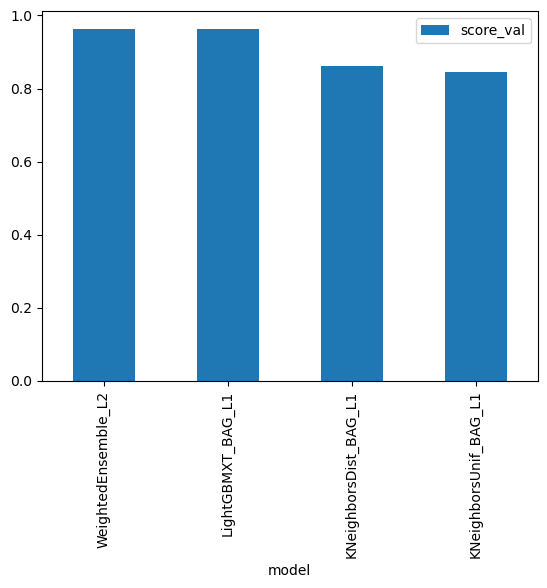

In [25]:
# Output the model's `score_val` in a bar chart to compare performance
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val");

In [26]:
#Haven't executed (Long runtime)
predictor.feature_importance(df_train)

Computing feature importance via permutation shuffling for 188 features using 5000 rows with 5 shuffle sets...
	10273.03s	= Expected runtime (2054.61s per shuffle set)

KeyboardInterrupt



In [27]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                   model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    WeightedEnsemble_L2   0.963429      85.712581  431.026978                0.157378           8.473840            2       True          4
1      LightGBMXT_BAG_L1   0.962824      12.638178  421.864327               12.638178         421.864327            1       True          3
2  KNeighborsDist_BAG_L1   0.861495      72.917025    0.688811               72.917025           0.688811            1       True          2
3  KNeighborsUnif_BAG_L1   0.846593      67.678601    0.784610               67.678601           0.784610            1       True          1
Number of models trained: 4
Types of models trained:
{'StackerEnsembleModel_KNN', 'StackerEnsembleModel_LGB', 'WeightedEnsembleModel'}
Bagging used: True  (with 8 folds)
Multi-layer stack-ensembling used: False 
Feature Metadata (Pro

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.8465934065934065,
  'KNeighborsDist_BAG_L1': 0.8614945054945055,
  'LightGBMXT_BAG_L1': 0.9628241758241758,
  'WeightedEnsemble_L2': 0.9634285714285714},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif_BAG_L1': 'AutogluonModels/ag-20230328_203010/models/KNeighborsUnif_BAG_L1/',
  'KNeighborsDist_BAG_L1': 'AutogluonModels/ag-20230328_203010/models/KNeighborsDist_BAG_L1/',
  'LightGBMXT_BAG_L1': 'AutogluonModels/ag-20230328_203010/models/LightGBMXT_BAG_L1/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20230328_203010/models/WeightedEnsemble_L2/'},
 'model_fit_times': {'KNeighborsUnif_BAG_L1': 0.7846102714538574,
  'KNeighborsDist_BAG_L1': 0.6888110637664795,
  'LightGBMXT_BAG_L1': 421.8643267

In [34]:
predictions = predictor.predict(df_test)
predictions.head(50)

0     0
1     1
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    1
23    0
24    0
25    0
26    1
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    1
44    0
45    0
46    1
47    0
48    0
49    1
Name: target, dtype: int64

In [33]:
perf = predictor.evaluate_predictions(y_true=df_test.target, y_pred=predictions, auxiliary_metrics=False)

Evaluation: accuracy on test data: 0.8416923076923077
Evaluations on test data:
{
    "accuracy": 0.8416923076923077
}
